In [44]:
import torch
from torch import nn
from torch.utils.data import DataLoader,random_split
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,),(0.3081,))
])

trainData = torchvision.datasets.MNIST(
  root='./dataset',
  train=True,
  download=True,
  transform=transform
)

testData = torchvision.datasets.MNIST(
  root='./dataset',
  train=False,
  download=True,
  transform=transform
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_size = int( len(trainData) * 0.9 )
val_size = len(trainData) - train_size

train_set, val_set = random_split(trainData,[train_size,val_size])

batch_size = 64
trainLoader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
valLoader = DataLoader(val_set,batch_size=batch_size)
testLoader = DataLoader(testData,batch_size=batch_size)

class MNist(nn.Module):
  def __init__(self, input_size, output_size=10):
    super().__init__()
    self.input_size = input_size
    self.c1 = nn.Linear(input_size,512)
    self.c2 = nn.Linear(512,256)
    self.c3 = nn.Linear(256,128)
    self.c4 = nn.Linear(128,64)
    self.c5 = nn.Linear(64,output_size)
  
  def forward(self,x):
    x = x.reshape(-1,self.input_size)
    x = torch.relu(self.c1(x))
    x = torch.relu(self.c2(x))
    x = torch.relu(self.c3(x))
    x = torch.relu(self.c4(x))
    return torch.relu(self.c5(x))
  
loss = nn.CrossEntropyLoss()

def train(model,trainLoader,epoches,loss,lr):
  model.train()
  opt = torch.optim.Adam(model.parameters(),lr)
  losses = []
  for epoch in range(epoches):
    los = 0
    total = 0
    for x,y in trainLoader:
      opt.zero_grad()
      x = x.to(device)
      y = y.to(device)
      y = F.one_hot(y,num_classes=10).float()
      l = loss(model(x),y)
      l.backward()
      opt.step()
      los += l.sum().item()
      total += y.size(0)
    losses.append(los/total)
  return losses


[0.009318793867611223, 0.006153751762652838, 0.005909346334636211, 0.005281066490406239, 0.005336934426454483, 0.005168669946077798, 0.00514713076715944, 0.005114692975318543, 0.005023930279055127, 0.005026663967442733, 0.004900622517991535, 0.0048910552917945166, 0.0047831090917051945, 0.004996625223300523, 0.0047293485483085665]


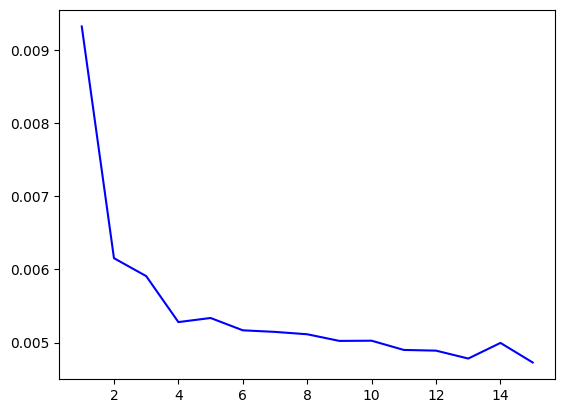

In [51]:
n_samples = trainData.data.shape[0]
input_size = trainData.data.reshape(n_samples,-1).shape[1]
model = MNist(input_size).to(device)

losses = train(model,trainLoader,10,loss,0.005)

print(losses)

plt.plot(range(1,len(losses)+1),losses,color='blue')
plt.show()

In [52]:
torch.save(model.state_dict(), './model.pth')

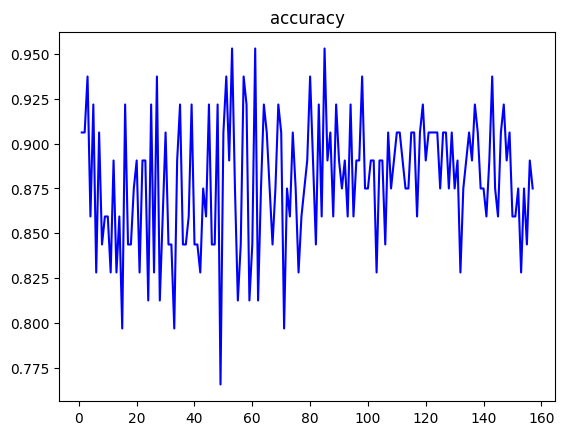

tensor(0.9531) tensor(0.7656)


In [53]:
model.eval()
total = 0
arr = []
with torch.no_grad():
    model.to('cpu')
    for x,y in testLoader:
        predict = model(x)
        predict = torch.argmax(predict,dim=-1)
        num = torch.sum(predict == y,dim=0)
        total = y.size(0)
        arr.append(num/total)
    plt.plot(range(1,len(arr)+1),arr,color='blue')
    plt.title('accuracy')
    plt.show()
    print(max(arr),min(arr))
         